In [1]:
train_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 256, 256 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

Using TensorFlow backend.


In [3]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14507 images belonging to 2 classes.
Found 3615 images belonging to 2 classes.
Found 4535 images belonging to 2 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50, NASNetLarge
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

resnet50_model = ResNet50(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

#resnet50_model.trainable=True

In [6]:
import keras
output = resnet50_model.layers[-1].output 
#output = keras.layers.Flatten()(output) 
resnet50_model = Model(resnet50_model.input, output) 

 
resnet50_model.trainable = False

#for layer in resnet50_model.layers[:-20]:
#    layer.trainable = False

In [7]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in resnet50_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001D05F70C288>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001D055738F88>,conv1_pad,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D05FD48F08>,conv1_conv,False
3,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001D05FE96EC8>,conv1_bn,False
4,<tensorflow.python.keras.layers.core.Activation object at 0x000001D0600700C8>,conv1_relu,False
...,...,...,...
170,<tensorflow.python.keras.layers.core.Activation object at 0x000001D04F797708>,conv5_block3_2_relu,False
171,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D04F798B48>,conv5_block3_3_conv,False
172,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001D04F7EF908>,conv5_block3_3_bn,False
173,<tensorflow.python.keras.layers.merge.Add object at 0x000001D04F7F0308>,conv5_block3_add,False


In [8]:
resnet50_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [10]:

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical 
from keras import optimizers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
# build model architecture 
model = Sequential()
model.add(resnet50_model)
model.add(Flatten())
#model.add(GlobalAveragePooling2D())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(num_class, activation='softmax'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 262146    
Total params: 23,849,858
Trainable params: 262,146
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [11]:
history = model.fit_generator(train, steps_per_epoch=64, 
                              epochs=30,  
                              validation_data=val,   
                              validation_steps=32,  
                              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 64 steps, validate for 32 steps
Epoch 1/30
64/64 [==============================] - 16s 249ms/step - loss: 0.5345 - accuracy: 0.7720 - f1_m: 0.7720 - precision_m: 0.7720 - recall_m: 0.7720 - val_loss: 0.7898 - val_accuracy: 0.5234 - val_f1_m: 0.5234 - val_precision_m: 0.5234 - val_recall_m: 0.5234
Epoch 2/30
64/64 [==============================] - 11s 172ms/step - loss: 0.4292 - accuracy: 0.8809 - f1_m: 0.8809 - precision_m: 0.8809 - recall_m: 0.8809 - val_loss: 0.7898 - val_accuracy: 0.5234 - val_f1_m: 0.5234 - val_precision_m: 0.5234 - val_recall_m: 0.5234
Epoch 3/30
64/64 [==============================] - 11s 172ms/step - loss: 0.3797 - accuracy: 0.9326 - f1_m: 0.9326 - precision_m: 0.9326 - recall_m: 0.9326 - val_loss: 0.7898 - val_accuracy: 0.5234 - val_f1_m: 0.5234 - val_precision_m: 0.5234 - val_recall_m: 0.5234
Epoch 4/30
64/64 [=============

Epoch 30/30
64/64 [==============================] - 11s 174ms/step - loss: 0.3260 - accuracy: 0.9868 - f1_m: 0.9868 - precision_m: 0.9868 - recall_m: 0.9868 - val_loss: 0.7898 - val_accuracy: 0.5234 - val_f1_m: 0.5234 - val_precision_m: 0.5234 - val_recall_m: 0.5234


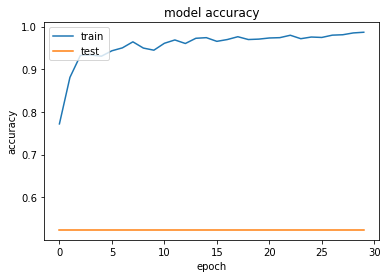

In [12]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

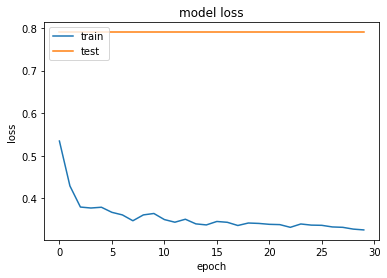

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

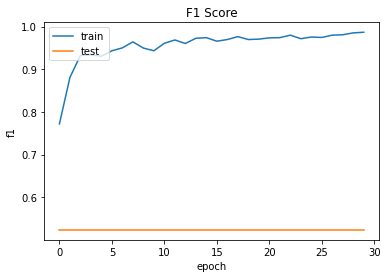

In [14]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

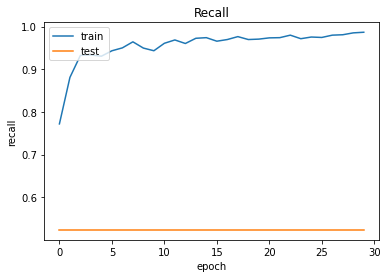

In [15]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

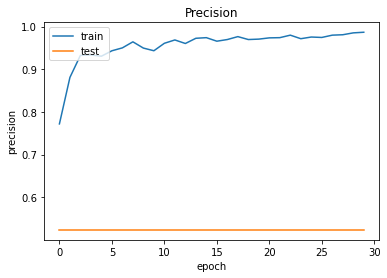

In [16]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos de test para evaluar el modelo
  ...
    to  
  ['...']
142/142 [==============================] - 18s 128ms/step - loss: 0.7852 - accuracy: 0.5281 - f1_m: 0.5280 - precision_m: 0.5280 - recall_m: 0.5280
El modelo predice el  52.81146764755249 % de los datos


In [18]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos de test para evaluar el modelo
Loss:  0.7852457064977834
Accuracy:  0.5281147
F1 Score:  0.5280159
Precision:  0.528016
Recall:  0.528016


In [19]:
articulo_dir='D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Implementacion/Deteccion_Articulo/dataset,solocovid,pneumonia'
#Para el conjunto del artículo
articulo_generator = train_datagen.flow_from_directory(
    articulo_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
articulo=articulo_generator

Found 351 images belonging to 2 classes.


In [20]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
test_eval = model.evaluate(articulo, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos del artículo para evaluar el modelo
  ...
    to  
  ['...']
11/11 [==============================] - 6s 557ms/step - loss: 0.9796 - accuracy: 0.3333 - f1_m: 0.3337 - precision_m: 0.3337 - recall_m: 0.3337
El modelo predice el  33.33333432674408 % de los datos


In [21]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos del artículo para evaluar el modelo
Loss:  0.979592274535786
Accuracy:  0.33333334
F1 Score:  0.3336693
Precision:  0.33366936
Recall:  0.33366936
